In [1]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
import numpy as np
from PIL import Image

C:\Users\ve59kedo\.conda\envs\HUNet\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



# In this part two list of paths are created. then they are removed if the annotated part of it is less than 5%


In [2]:


# Define the directory where the dataset is stored and the tile sizes for processing
data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/Tiles_0.9_256_64_np'
tile_size1 = (256, 256)          # Size of the image tiles
tile_size2 = (256, 256, 1)       # Size with channel information
input_shape = (256, 256, 3)      # Input shape for the U-Net model

# Lists to store the paths of the image and label files
x = []  # Image file paths
y = []  # Label file paths

# Iterate through the sorted list of files in the data directory
for filename in natsorted(os.listdir(data_dir)):
    # Append label file paths to 'y'
    if filename.endswith('labelled.npy'):
        y.append(os.path.join(data_dir, filename))
        
    # Append image file paths to 'x'
    if filename.endswith('].npy'):
        x.append(os.path.join(data_dir, filename))



# Lists to store the paths of images with unique classes
full_set_y = []  # Paths for label files with unique classes
full_set_x = []  # Corresponding image file paths
counter = 0      # Counter for tracking filtered samples

# Create a copy of the original 'y' list
y_copy = y.copy()

# Loop through the label files to filter out samples based on unique classes
unique_classes_encountered = set()
total_pixels = 256 * 256  # Total number of pixels in an image

for i in range(len(y)):
    lbl_arr_path = y[i]
    img = np.array(np.load(lbl_arr_path))
    unique_classes = np.unique(img)
    
    # Check for unique classes between 1 and 12
    unique_classes_1_to_12 = [cls for cls in unique_classes if 1 <= cls <= 12]
    for cls in unique_classes_1_to_12:
        img_clc = (img == cls)
        num_ones = np.sum(img_clc == 1)
        percentage_ones = (num_ones / total_pixels) * 100.
        
        # Include the label path if a unique class covers at least 5% of the image
        if percentage_ones >= 5.0:
            if lbl_arr_path not in full_set_y:
                full_set_y.append(lbl_arr_path)
        else:
            counter += 1

# Create a list of image paths corresponding to the selected label files
for mask_path in full_set_y:
    image_path = mask_path.replace('-labelled', '')
    full_set_x.append(image_path)

# Define a list of specific test set identifiers
test_path_list = []

# Split the full set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(full_set_x, full_set_y, test_size=0.15, random_state=42)

# Lists to store test set paths
X_test = []  # Image file paths for the test set
Y_test = []  # Label file paths for the test set
indices_to_delete = []  # Indices of samples to remove from the training set

# Separate out the test set based on the identifiers in test_path_list
for i, (img, label) in enumerate(zip(X_train, Y_train)):
    if any(name in img for name in test_path_list):
        Y_test.append(label)
        X_test.append(img)
        indices_to_delete.append(i)

# Remove test set samples from the training set
for index in sorted(indices_to_delete, reverse=True):
    X_train.pop(index)
    Y_train.pop(index)

# Print the sizes of the different datasets
print("Dataset Sizes:")
print(f"killed {counter} unpure samples")
print(f"full set: {len(full_set_x)} samples")
print(f"Training set: {len(X_train)} samples = {((len(X_train)/len(full_set_x))*100):.2f}%")
print(f"Validation set: {len(X_val)} samples = {((len(X_val)/len(full_set_x))*100):.2f}%")
print(f"Test set: {len(X_test)} samples = {((len(X_test)/len(full_set_x))*100):.2f}%")


Dataset Sizes:
killed 9583 unpure samples
full set: 18263 samples
Training set: 13706 samples = 75.05%
Validation set: 2740 samples = 15.00%
Test set: 1817 samples = 9.95%


# lets look at the data, one with alot classes in it

(256, 256) [0 1 2 7]


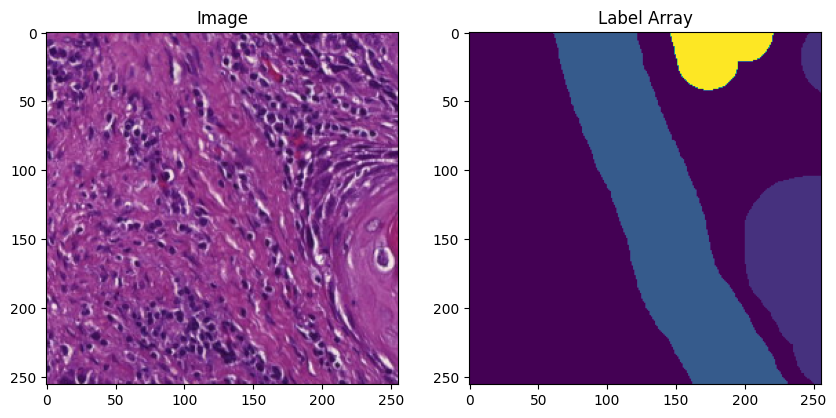

In [3]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with 1 row and 2 columns, each subplot with a size of 10x5 inches
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  

# Loop through each index in the length of Y_train
for i in range(len(Y_train)):

    # Load the label array from the Y_train dataset
    lbl_arr = np.load(Y_train[i])

    # Check if the label array has more than 3 unique values
    if len(np.unique(lbl_arr)) > 3:
        # Print the shape of the label array and its unique values
        print(np.shape(lbl_arr), np.unique(lbl_arr))

        # Load the corresponding image from the X_train dataset
        img = np.load(X_train[i])
        
        # Display the image in the first subplot
        axs[0].imshow(img)
        axs[0].set_title("Image")
        
        # Display the label array in the second subplot
        axs[1].imshow(lbl_arr)
        axs[1].set_title("Label Array")
        
        # Render the plots
        plt.show()
        break  # Exit the loop after processing the first qualifying image-label pair


# here we define the data generator for training. it generates batch of data, augments them, preprocesses them in different channels and also creates two new channels white bg and not annotated

In [3]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True,num_class=4,remove_bg=0):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.class_names = [
            'Not_annotated',
            'Tumor',
            'All_Other',
            'White_BG'
        ]
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.num_class = num_class
        self.remove_bg = remove_bg
        self.unique = np.arange(0, 12, 1)
        if self.remove_bg:
            self.class_names = self.class_names[1:]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            # Store sample
            img_arr = np.load(sample_path)
            img_arr = np.resize(img_arr, (256,256,3))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr /= 255.0 # normalize

            # Store label
            lbl_arr = np.load(label_path)
            lbl_arr = np.resize(lbl_arr, (256,256))
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], self.num_class), dtype=np.float32)

            for i, value in enumerate(self.unique):
                if value in [1]:  # Class 1: Tumor,
                    channels[:, :, 1] += (lbl_arr == value).astype(np.uint8)
                elif value == 0:  # Class 0: Not annotated
                    channels[:, :, 0] = (lbl_arr == value).astype(np.uint8)
                elif value in [2, 3, 4, 5, 6, 7, 9, 10, 11, 12]:  # All other classes
                    channels[:, :, 2] += (lbl_arr == value).astype(np.uint8)
                    
                    

            # Apply Gaussian smoothing with a specified sigma (adjust sigma as needed)
            sigma = 8.0
            img_arr_smoothed = gaussian_filter(img_arr, sigma=sigma)

            # Threshold the image to make white pixels more visible
            threshold = 0.75
            img_arr_smoothed = np.mean(img_arr_smoothed,axis=2)
            img_arr_smoothed[img_arr_smoothed >= threshold] = 1.0
            img_arr_smoothed[img_arr_smoothed < threshold] = 0.0


            channels[:,:,-1] = img_arr_smoothed

            for i in range(0, self.num_class - 1):

                # Perform a bitwise AND operation to get the overlapping region
                overlap = (channels[:, :, i].astype(bool) & img_arr_smoothed.astype(bool)).astype(np.uint8)

                # Perform a bitwise XOR operation to delete the overlapping region from mask1
                channels[:, :, i] = (channels[:, :, i].astype(bool) ^ overlap).astype(np.uint8)

            lbl_arr = channels
            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images

    def viz(self, x_images, y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, len(self.class_names)+1, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(0, len(self.class_names)):
                axs[i+1].imshow(y_mask[:, :, i])
                axs[i+1].axis('off')  # Remove axes
                axs[i+1].set_title(f'{self.class_names[i]}_{i}', fontsize=9)
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')
    
    

# lets look at a batch!

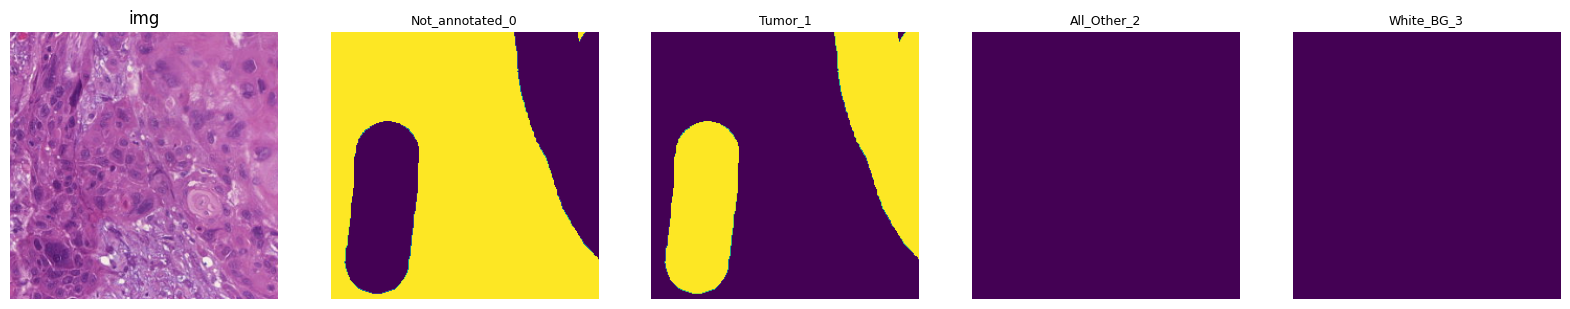

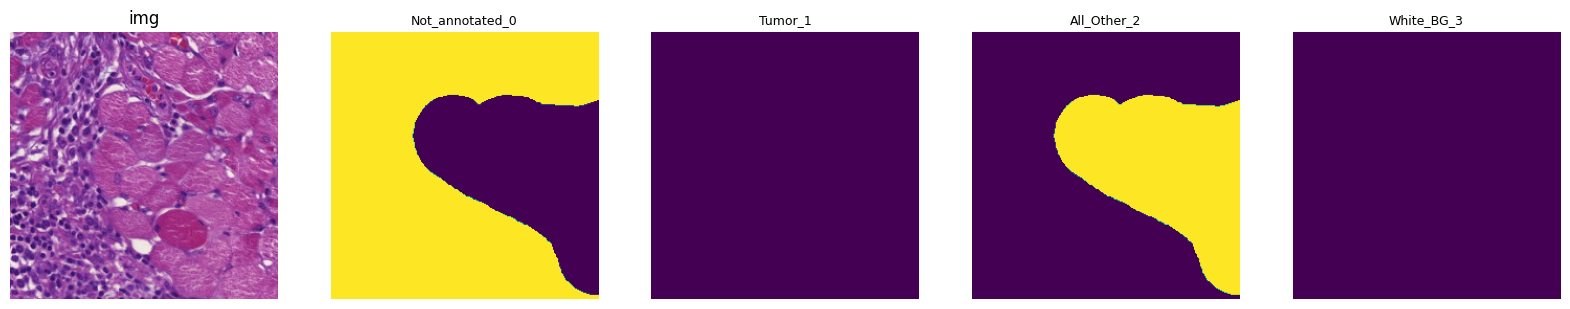

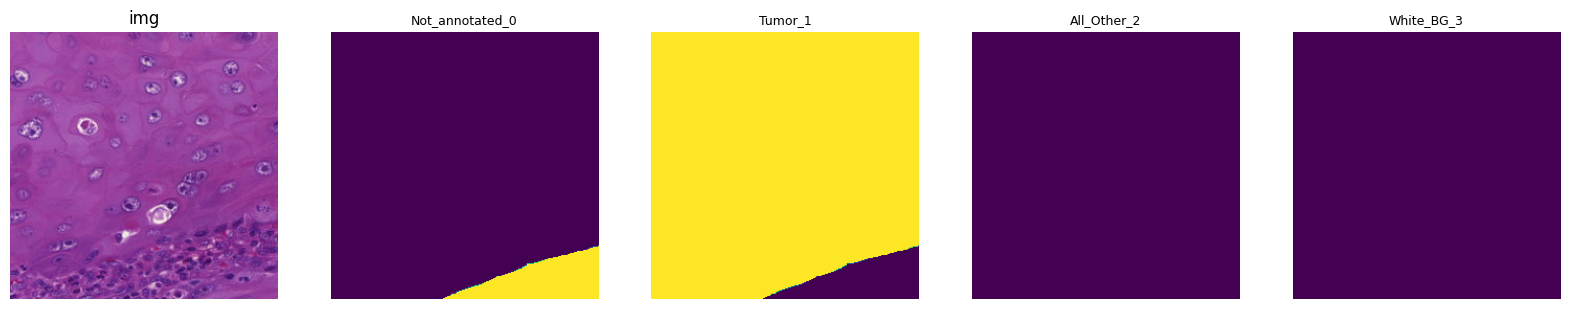

Batch shape (3, 256, 256, 3) and for masks (3, 256, 256, 4)
image shape (256, 256, 3) and for masks (256, 256, 4)
max value for images is 1.0 and for masks 1.0
min value for images is 0.01568627543747425 and for masks 0.0
number of unique values in images is 251 and for masks [0. 1.]


In [5]:
test = DataGenerator(X_train,Y_train,batch_size=3,aug=0)
a,b = test.__getitem__(1)
test.viz(a,b)

In [ ]:
# here I colculated the weights for each channel but since the seting is changed this has no use anymore




# weight = DataGenerator(X_train,Y_train,batch_size=len(Y_train),aug=0)
# wa,wb = weight.__getitem__(0)

# def count_ones_per_channel(mask_list):
#     num_channels = mask_list[0].shape[-1]
#     result = [0] * num_channels

#     for mask in mask_list:
#         for channel in range(num_channels):
#             result[channel] += np.sum(mask[..., channel])
#     class_occurrences = np.array(result)
#     class_weights = np.sum(class_occurrences) / (4 * class_occurrences)

#     return class_weights

# class_weights = count_ones_per_channel(wb)

# class_weights[0] = 0.0
# print(class_weights)

# #[ 0.          0.59198031  1.30321259  2.79301012  3.36147768 23.01366383
# # 12.24642511  2.5611076  28.53949286  5.26079142 18.98749463 85.53032634
# # 26.01193567  3.99163897]
# # [0.         2.07003102 2.26157745 9.18819039]

# intialazing the model and definging the metrics

In [1]:
# making weights for each class. zero for the first class (not annotated) since we dont want the network to learn that.

class_weights = [0.         ,1. ,1. ,1.]

In [14]:
from segmentation_models import Unet
from tensorflow.keras.applications import EfficientNetB0

# Making the unet model
model = Unet('efficientnetb0', classes=4, activation='softmax',input_shape=(256, 256, 3), decoder_filters=(512, 256, 128, 64, 32))


In [15]:
from segmentation_models.losses import *
from segmentation_models.metrics import *

# Define a weighted Dice loss for multi-class segmentation.
# The 'class_weights' variable should be defined elsewhere in the code, containing weights for each class.
WDL = DiceLoss(class_weights=class_weights)

# Define the Intersection over Union (IoU) score as a metric for evaluating segmentation performance.
metric = IOUScore()

# Convert class weights to a TensorFlow constant tensor, which is necessary for the loss functions.
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

# Define a weighted categorical cross-entropy loss with the class weights.
WCat = CategoricalCELoss(class_weights=class_weights_tensor)

def calculate_intersection(class_index, pred_mask, true_mask):
    # Get the predicted and true masks for a specific class index.
    pred_class_mask = tf.cast(pred_mask[..., class_index], dtype=tf.float32)
    true_class_mask = tf.cast(true_mask[..., class_index], dtype=tf.float32)

    # Calculate the intersection by finding the minimum value at each pixel location.
    intersection = tf.reduce_sum(tf.math.minimum(pred_class_mask, true_class_mask))

    # Calculate the union for the true mask.
    union = tf.reduce_sum(true_class_mask)

    # Add a small value to avoid division by zero in case union is 0.
    epsilon = 1e-7
    union = tf.maximum(union, epsilon)

    # Calculate the Intersection over Union (IoU) score for the class.
    iou = intersection / union

    return iou

# The following functions are specific IoU calculations for each class channel.
# These can be used as metrics for a multi-channel segmentation model output.
def ch_0(y_true, y_pred):
    return calculate_intersection(0, y_pred, y_true)

def ch_1(y_true, y_pred):
    return calculate_intersection(1, y_pred, y_true)

def ch_2(y_true, y_pred):
    return calculate_intersection(2, y_pred, y_true)

def ch_3(y_true, y_pred):
    return calculate_intersection(3, y_pred, y_true)

# These are simply aliases for the IoU calculation functions for each class channel.
I_0 = ch_0
I_1 = ch_1
I_2 = ch_2
I_3 = ch_3


# Here we define the optimizer, compile and train the model

In [16]:
# Import necessary classes from Keras
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

# Initialize a callback to reduce the learning rate when a metric has stopped improving.
# Here it monitors 'loss', reduces the learning rate by a factor of 0.1 after 10 epochs with no improvement.
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)

# Initialize the SGD optimizer with a learning rate of 0.1 and momentum of 0.9.
sgd_with_momentum = SGD(lr=0.1, momentum=0.9)

# Compile the model with the specified optimizer, loss function, and metrics.
# 'WCat' is the weighted categorical cross-entropy loss function defined earlier.
# 'I_0', 'I_1', 'I_2', 'I_3' are the IoU metrics for each class, also defined earlier.
model.compile(optimizer=sgd_with_momentum,
              loss=WCat,   # Use the custom loss function
              metrics=[I_0, I_1, I_2, I_3])  # Use the custom IoU metrics for evaluation

# Fit the model on the data generated by the DataGenerator.
# The DataGenerator for training has data augmentation enabled (aug=1).
# The DataGenerator for validation has no data augmentation (aug=0).
# The model will train for 100 epochs, and the learning rate will be reduced upon plateau in loss.
history = model.fit(DataGenerator(X_train, Y_train, batch_size=32, aug=1),
                    epochs=100,
                    validation_data=DataGenerator(X_val, Y_val, batch_size=64, aug=0),
                    callbacks=[reduce_lr]  # Include the learning rate reduction callback
                    )


C:\Users\ve59kedo\.conda\envs\HUNet\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
428/428 [==============================] - 1294s 3s/step - loss: 0.0232 - ch_0: 0.0045 - ch_1: 0.7715 - ch_2: 0.8093 - ch_3: 0.8844 - val_loss: 0.0132 - val_ch_0: 7.2365e-04 - val_ch_1: 0.9419 - val_ch_2: 0.8661 - val_ch_3: 0.8991 - lr: 0.1000
Epoch 2/100
428/428 [==============================] - 463s 1s/step - loss: 0.0106 - ch_0: 5.7280e-04 - ch_1: 0.9061 - ch_2: 0.9184 - ch_3: 0.9352 - val_loss: 0.0089 - val_ch_0: 4.5004e-04 - val_ch_1: 0.9233 - val_ch_2: 0.9284 - val_ch_3: 0.9092 - lr: 0.1000
Epoch 3/100
428/428 [==============================] - 455s 1s/step - loss: 0.0082 - ch_0: 4.6314e-04 - ch_1: 0.9301 - ch_2: 0.9391 - ch_3: 0.9380 - val_loss: 0.0074 - val_ch_0: 3.9299e-04 - val_ch_1: 0.9350 - val_ch_2: 0.9454 - val_ch_3: 0.9516 - lr: 0.1000
Epoch 4/100
428/428 [==============================] - 451s 1s/step - loss: 0.0071 - ch_0: 3.9186e-04 - ch_1: 0.9401 - ch_2: 0.9479 - ch_3: 0.9417 - val_loss: 0.0076 - val_ch_0: 2.9329e-04 - val_ch_1: 0.9126 - val_ch_2: 0.9699

# lets look at the histort.history

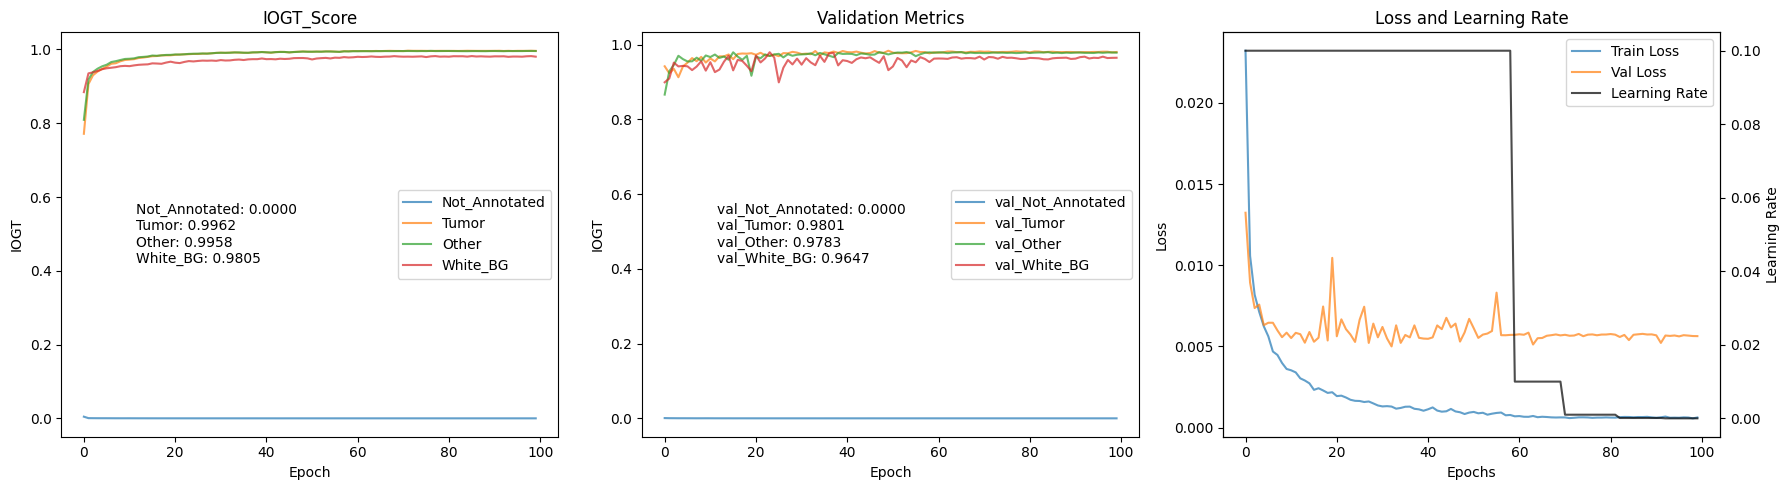

In [17]:
class_names = [
    'Not_Annotated',
    'Tumor',
    'Other',
    'White_BG']

# Create a figure with 3 subplots side by side and set the figure size.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.flatten()

# Set transparency for the plot lines.
alpha_value = 0.7

# Lists to store the last recorded values of the training and validation metrics.
last_values_train = []  # Training metrics
last_values_val = []    # Validation metrics

# Plot the IoU Score (here referred to as IOGT) for each class in the first subplot.
for i, class_name in enumerate(class_names):
    metric_name = f'ch_{i}'  # Name of the training metric
    val_metric_name = f'val_{metric_name}'  # Name of the validation metric
    
    # Get the history of the metric values for both training and validation.
    metric_values = history.history[metric_name]
    val_metric_values = history.history[val_metric_name]
    
    # Plot the training metric values with transparency.
    axes[0].plot(metric_values, label=f'{class_name}', alpha=alpha_value)
    # Setup the title and axes labels.
    axes[0].set_title('IOGT_Score')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('IOGT')

    # Store the last recorded training metric value.
    last_values_train.append((class_name, metric_values[-1]))

# Plot the validation IoU Score for each class in the second subplot.
for i, class_name in enumerate(class_names):
    val_metric_name = f'val_ch_{i}'  # Name of the validation metric
    val_metric_values = history.history[val_metric_name]
    
    # Plot the validation metric values with transparency.
    axes[1].plot(val_metric_values, label=f'val_{class_name}', alpha=alpha_value)
    # Setup the title and axes labels.
    axes[1].set_title('Validation Metrics')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IOGT')

    # Store the last recorded validation metric value.
    last_values_val.append((f'val_{class_name}', val_metric_values[-1]))

# Plot the loss and validation loss in the third subplot.
line_loss, = axes[2].plot(history.history['loss'], label='train_loss', alpha=alpha_value)
line_val_loss, = axes[2].plot(history.history['val_loss'], label='val_loss', alpha=alpha_value)
# Setup the title and axes labels.
axes[2].set_title('Loss and Learning Rate')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')

# Create a secondary y-axis for the learning rate plot.
axes2 = axes[2].twinx()
line_lr, = axes2.plot(history.history['lr'], label='lr', color='black', alpha=alpha_value)
axes2.set_ylabel('Learning Rate')

# Add a legend to the first plot.
axes[0].legend(loc='center right')

# Add a text box with the last recorded training metric values inside the first subplot.
last_values_train_text = [f'{class_name}: {value:.4f}' for class_name, value in last_values_train]
axes[0].text(0.15, 0.5, '\n'.join(last_values_train_text), transform=axes[0].transAxes, va='center')

# Add a legend to the second plot.
axes[1].legend(loc='center right')

# Add a text box with the last recorded validation metric values inside the second subplot.
last_values_val_text = [f'{class_name}: {value:.4f}' for class_name, value in last_values_val]
axes[1].text(0.15, 0.5, '\n'.join(last_values_val_text), transform=axes[1].transAxes, va='center')

# Add a legend to the third plot.
axes[2].legend(handles=[line_loss, line_val_loss, line_lr], labels=['Train Loss', 'Val Loss', 'Learning Rate'], loc='upper right')

# Adjust the layout to avoid overlap.
plt.tight_layout()
# Save the figure as a PNG file to a specified directory.
plt.savefig('D:/Hamed/Forschungsproject/Hancock 2/32MIT_results/metrics.png')
# Display the plot.
plt.show()


# Saving the history and the model

In [18]:
import pickle

# Specify the directory path
save_path = 'D:/Hamed/Forschungsproject/Hancock 2/32MIT_results'

# Make sure the directory exists, create it if not
os.makedirs(save_path, exist_ok=True)

# Save the history object
with open(os.path.join(save_path, 'training_history.pkl'), 'wb') as file:
    pickle.dump(history.history, file)
    
# Save the weights
model.save(save_path + "/model_T32EFF")

# Evaluating the model

In [ ]:

DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=0)
a, b =DataGen.__getitem__(0)
score = model_T16.evaluate(a,b)

57/57 [==============================] - 11s 95ms/step - loss: 11.8638 - ch_0: 2.7837e-05 - ch_1: 0.9599 - ch_2: 0.9394 - ch_3: 0.9585


# Here we plot the test_data to see if the model is able to predict correctly. also each individual channels is plotted 

1/1 [==============================] - 2s 2s/step


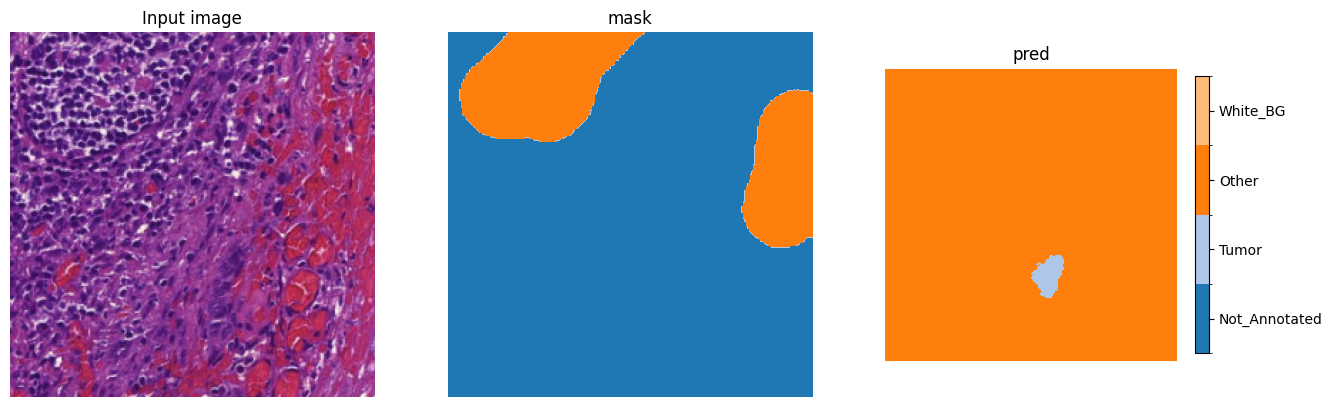

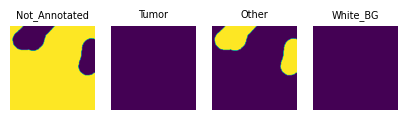

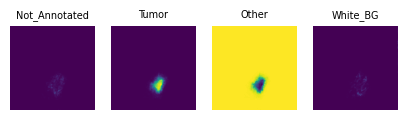

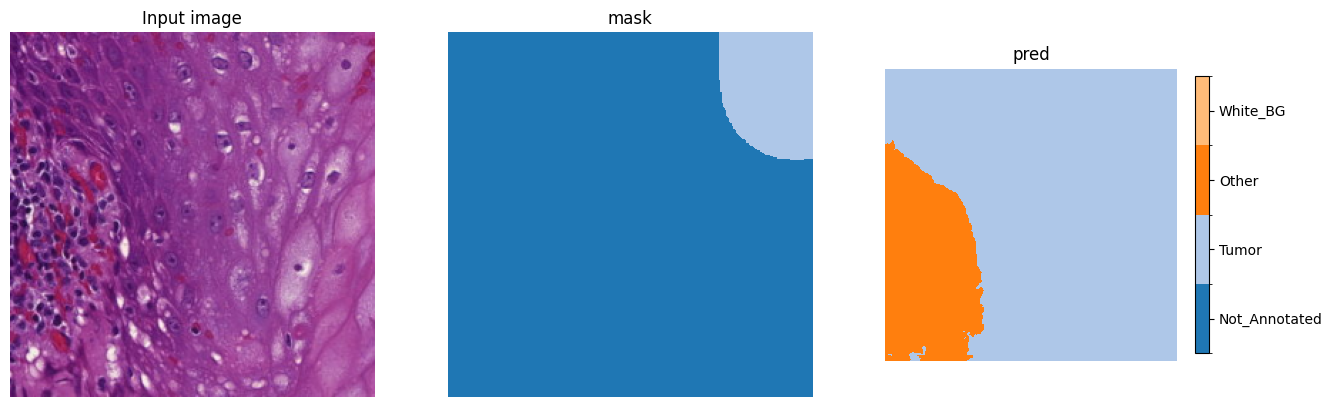

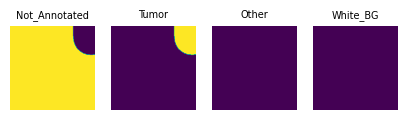

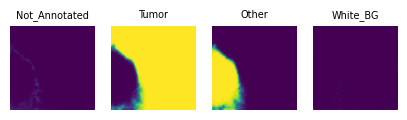

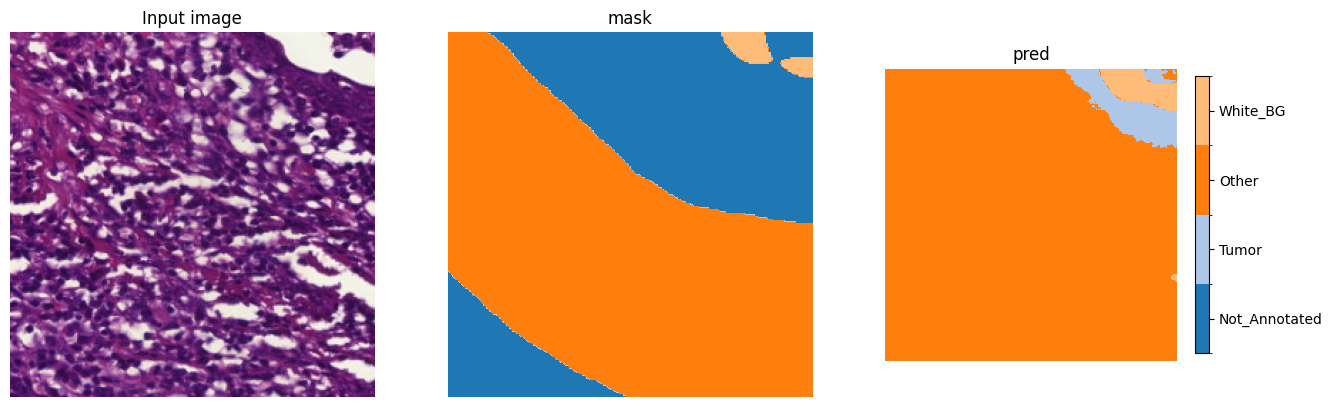

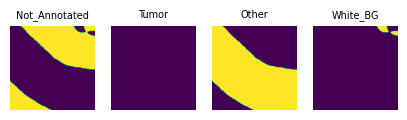

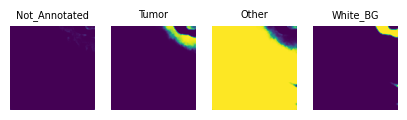

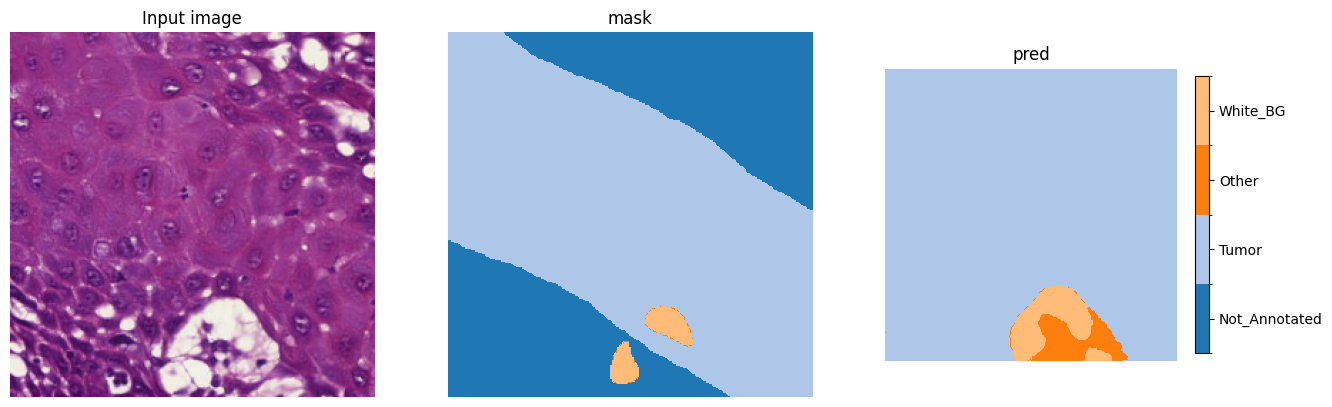

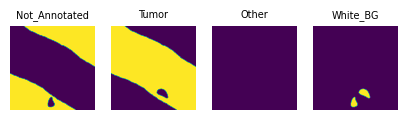

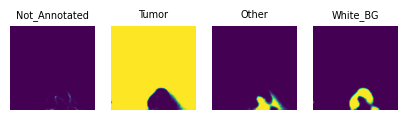

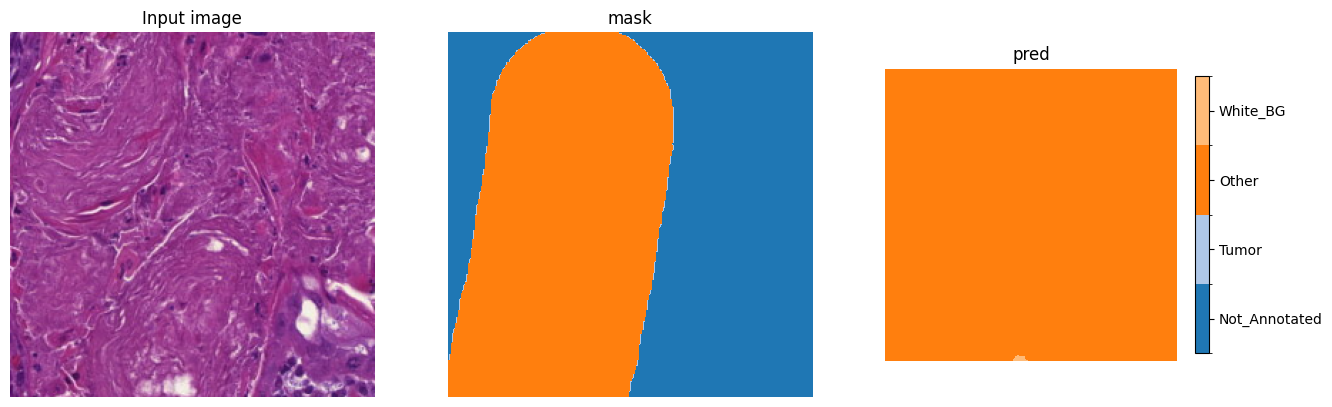

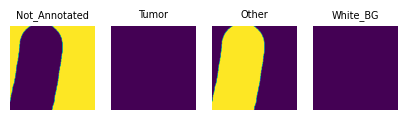

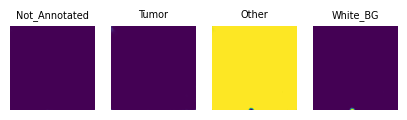

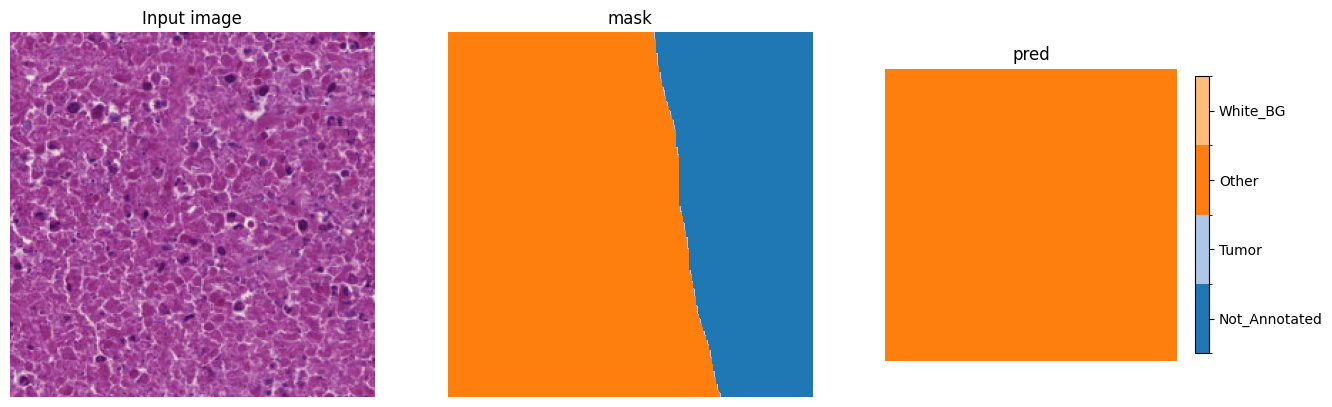

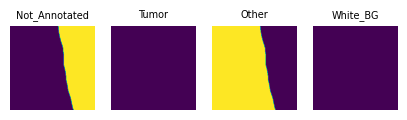

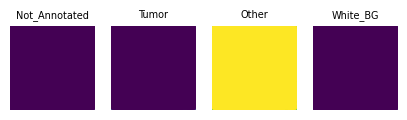

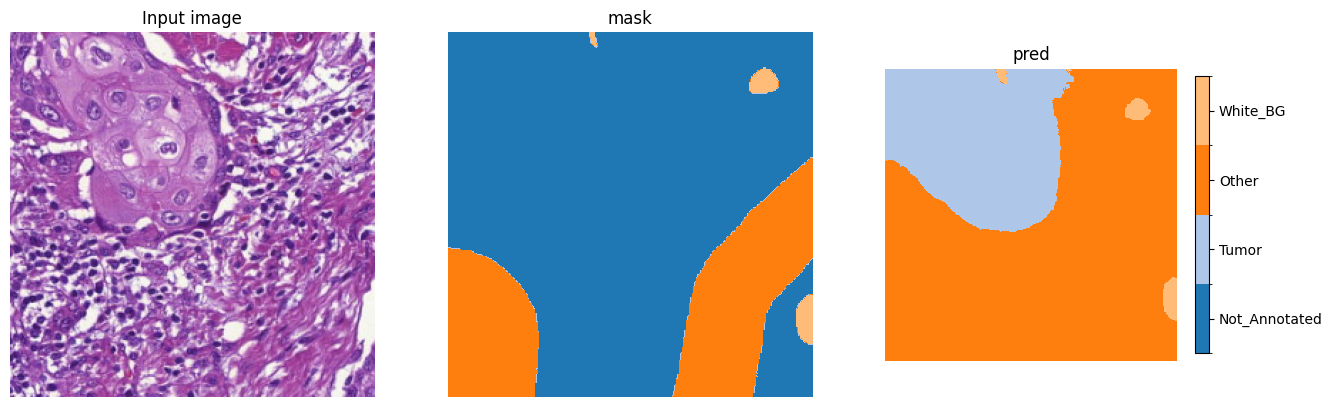

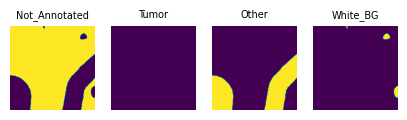

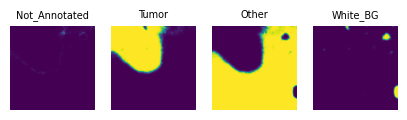

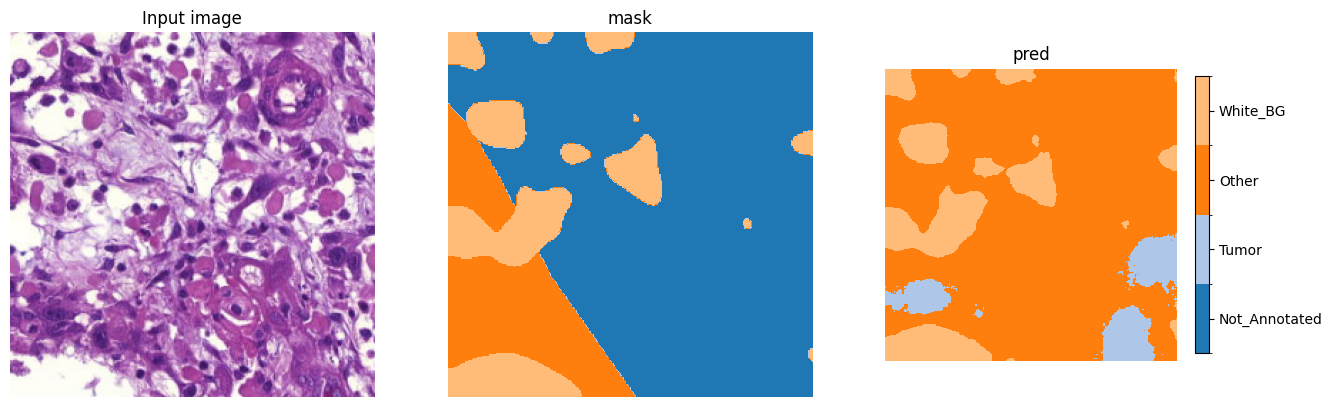

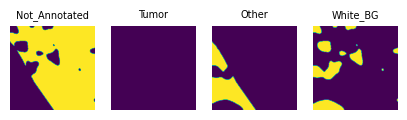

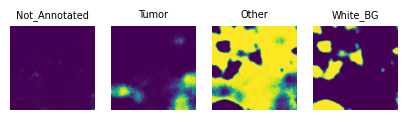

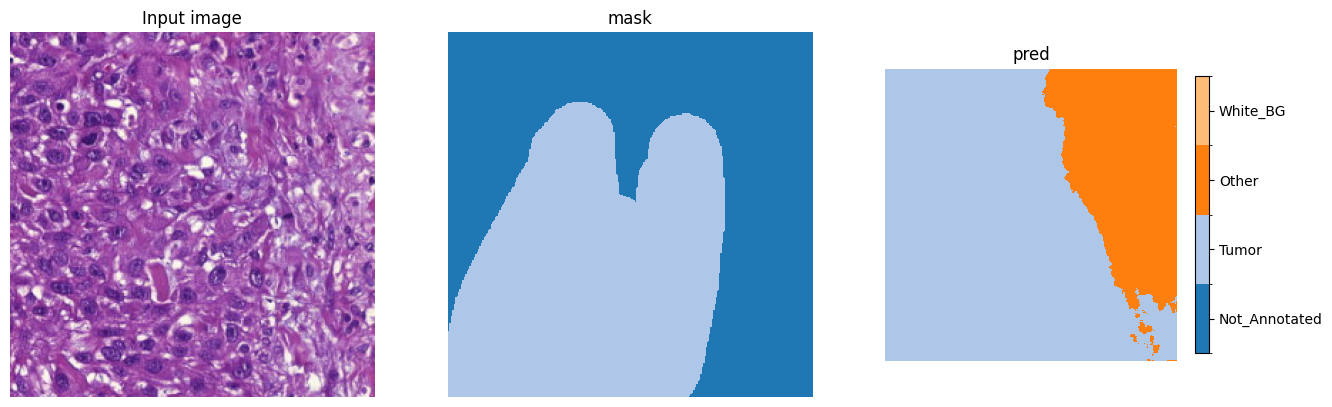

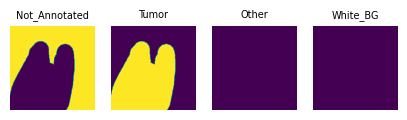

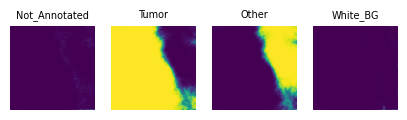

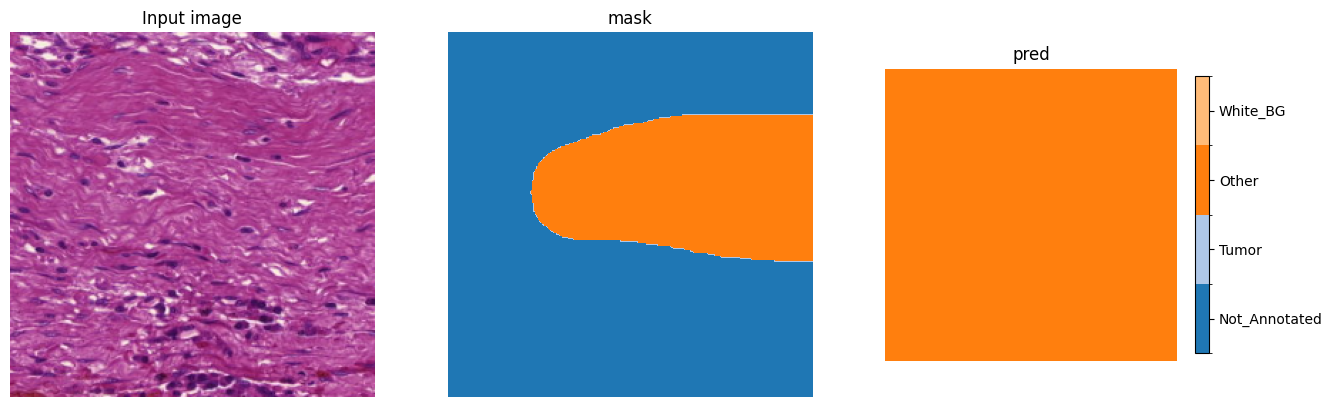

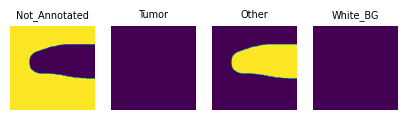

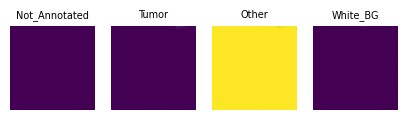

In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

class_names = [
            'Not_annotated',
            'Tumor',
            'Other',
            'White_BG']


DataGen = DataGenerator(X_test,Y_test, batch_size=10, aug=False)
img, mask = DataGen.__getitem__(0)
y_pred = model.predict(img)


for idx in range(np.shape(y_pred)[0]):
    # Plot the input image in the first subplot
   # Create the figure and axis
    fig, ax = plt.subplots(1, 3, figsize=(16, 12))

    # Plot the input image
    ax[0].imshow(img[idx])
    ax[0].set_title('Input image')
    ax[0].axis('off')

    empty = np.zeros((256, 256))
    # Loop through the images and plot them
    ans = np.argmax(mask[idx],axis=2)

    # Create a custom discrete colormap with 13 colors
    cmap = ListedColormap(plt.cm.tab20.colors[:4])
    bounds = np.arange(0, 5) -0.5 # Set boundaries of color segments
    norm = BoundaryNorm(bounds, cmap.N)
    ax[1].axis('off')

    im = ax[1].imshow(ans, cmap=cmap, norm=norm)
    ax[1].set_title('mask')

    empty = np.zeros((256, 256))
    # Loop through the images and plot them
    ans = np.argmax(y_pred[idx],axis=2)

    # Create a custom discrete colormap with 13 colors
    cmap = ListedColormap(plt.cm.tab20.colors[:4])
    ax[2].axis('off')


    im = ax[2].imshow(ans, cmap=cmap, norm=norm)
    ax[2].set_title('pred')

    # Add colorbar next to the second plot
    cbar = plt.colorbar(im, ax=ax[2], ticks=np.arange(0, 4), shrink=0.3)
    cbar.set_ticklabels(class_names)


    ##################################

    # Create the subplots
    fig, axs = plt.subplots(1, 4, figsize=(5, 2))

    # Loop through each subplot
    for i, ax in enumerate(axs.flat):
        ax.imshow(mask[idx][:, :, i])
        ax.axis('off')
        ans = np.mean(mask[idx][:, :, i])
        ax.set_title(f'{class_names[i]}', fontsize=7)

    plt.show()



    ###########################################

    # Create the subplots
    fig, axs = plt.subplots(1, 4, figsize=(5, 2))

    # Loop through each subplot
    for i, ax in enumerate(axs.flat):
        ax.imshow(y_pred[idx][:, :, i])
        ax.axis('off')
        ans = np.mean(y_pred[idx][:, :, i])
        ax.set_title(f'{class_names[i]}', fontsize=7)

    plt.show()
